In [1]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage import img_as_ubyte, transform, util
# from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
from PIL import Image
import csv
import pandas as pd
import openpyxl

2024-10-25 03:44:51.706912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# List available physical devices (GPUs should be listed here)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Check if TensorFlow is using the GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU")
else:
    print("TensorFlow is not using the GPU")


Available GPUs: []
TensorFlow is not using the GPU


2024-10-25 03:45:00.685807: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-25 03:45:00.687334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-10-25 03:45:00.711532: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-25 03:45:00.711556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


In [3]:
# Ensure reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

SIZE = 800
IMG_CHANNELS = 1

TRAIN_PATH = '/home/vcpuser/train 120 refined/'
TEST_PATH = '/home/vcpuser/test 80 refined/'

# os.walk is used to get a list of subdirectories within the TRAIN_PATH and TEST_PATH directories,
# and the resulting subdirectory names are stored in train_ids and test_ids, respectively.
train_ids = next(os.walk(TRAIN_PATH))[1]   # [1] retrieves only the subdirectories within the current directory
test_ids = next(os.walk(TEST_PATH))[1]

print(train_ids)
print(len(train_ids))
print(test_ids)
print(len(test_ids))


['3 min 1000 3', '7 min 1500 1', '10 min 1000 1', 'S7_2000_2', 's1 5 1000su-2 1', '205x1000 sur pos 1 1', '405 X1500 sur 1', '5V cyc1 4000 1 1', '405W X1000 sur 5 1', '3 min 2500 5', '40 10min p 4000 2 1', '3 min 1500 2', '3 min 1500 4', '20 1.5A 5min 1000 3 1', 's1 10 1000su 1', 's1 7 1000su 2', '40 1.5A 5min 1000 8 1', '40 1.5A 10min 1000 1 1', 'S5_2000_1', 'S3_1000_1', '5 min op 1500 su 1', '20 10min 1.5A 1000 1 1', '20 1.5A 10min 1000 5 1', 'S5_1000_2', '20 5min 1.5A 2000 3 1', 's1 2010 1500su 1', '10 min 2500 1', '5V cyc3 5000 2 1', '5 min op 1000 su 2', 'S7_2000_1', '5V cyc1 4000 3 1', '40 10min p 3000 1 1', 'DC 2step 100mA 350V-2 X2000 1', '7 min 2500 2', '5V cyc3 5000 3 1', 's1 2010 1000su 2', 's1 3 1500su 1', 's1 10 1500su 2', 'S7_1000_1', '10 min 2000 1', '20 1.5A 5min 1000 1 1', 'S3_1500_2', '3 min 2500 4', 's1 2010 1500su 2', '10 min 2500 2', 's1 5 1000su 1', '7 min 2000 2', '40 1.5A 10min 1000  4 1', '20 10min 1.5A 2000 2_2 1', 's1 205 1500su 2', '305 X2000 sur wp 1', '20 

In [4]:
# Define metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()
accuracy_metric = tf.keras.metrics.BinaryAccuracy()
# iou_metric = tf.keras.metrics.BinaryIoU(name='IoU')

def f1_score(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1


def IoU(y_true, y_pred):
    # Clip predictions and ground truths to binary values (0 or 1)
    y_true = tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1))
    y_pred = tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1))
    
    # Calculate the intersection and union
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    
    # Calculate IoU
    iou = intersection / (union + tf.keras.backend.epsilon())
    
    return iou

def adjust_contrast(image, contrast_factor):
    image = image.astype(np.float32)  # Convert image to float32 for precise computation
    mean = np.mean(image)
    return np.clip((image - mean) * contrast_factor + mean, 0, 255).astype(np.uint8)


2024-10-22 18:06:11.361809: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 18:06:11.361930: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-22 18:06:11.364404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:85:00.0 name: Tesla V100-SXM2-32GB-LS computeCapability: 7.0
coreClock: 1.44GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 772.48GiB/s
2024-10-22 18:06:11.364426: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-22 18:06:11.364452: I tensorflow/stream_executor/platform/def

In [5]:
### Train Images ###

# store the preprocessed images and their corresponding binary masks
# The dtype argument is set to np.uint8 for X_train and np.bool for Y_train to reduce memory usage.
X_train = np.zeros((len(train_ids), SIZE, SIZE, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), SIZE, SIZE, 1), dtype=bool)

print('Processing training data')

# Iterate through all the training IDs
for index, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    # Construct the paths for the image and mask
    img_path = f"{TRAIN_PATH}{id_}/image/{id_}.jpg"
    mask_path = f"{TRAIN_PATH}{id_}/mask/{id_}.png"

    # Load and normalize the image
    image = imread(img_path, as_gray=True)
    image = np.uint8(image)  # ensure the images to be 8-bit
    image = np.expand_dims(image, axis=-1)  # Ensure image has 3 dimensions
    X_train[index] = image

    # Load and prepare the mask
    mask = imread(mask_path, as_gray=True)
    mask = mask > 0  # Convert grayscale to binary mask
    mask = np.expand_dims(mask, axis=-1)  # Ensure mask has 3 dimensions
    Y_train[index] = mask

# Image augmentation for the training data
X_train_aug = []
Y_train_aug = []

for n in tqdm(range(len(X_train))):
    augmented_images = []
    augmented_masks = []

    for angle in [0, 90, 180, 270]:
        augmented_img_rotate = transform.rotate(X_train[n], angle, mode='reflect')
        augmented_mask_rotate = transform.rotate(Y_train[n], angle, mode='reflect')

        augmented_images.append(img_as_ubyte(augmented_img_rotate))  # img_as_ubyte: Convert to 8-bit uint.
        augmented_masks.append(augmented_mask_rotate > 0)  # Ensure masks remain binary

    augmented_images.extend([img_as_ubyte(np.fliplr(img)) for img in augmented_images])
    augmented_masks.extend([np.fliplr(mask) > 0 for mask in augmented_masks])  # Flip and convert masks to binary

    for img in augmented_images:
        contrast_factor = random.uniform(0.5, 1.5)  # Randomly choose a contrast factor between 0.1 and 2
        img_contrast = adjust_contrast(img, contrast_factor)
        X_train_aug.append(img_contrast)

    Y_train_aug.extend(augmented_masks)

X_train_aug = np.array(X_train_aug, dtype=np.uint8)
Y_train_aug = np.array(Y_train_aug, dtype=bool)

print("X_train_aug length: ", len(X_train_aug))
print("Y_train_aug length: ", len(Y_train_aug))

Processing training data


100%|██████████| 120/120 [02:24<00:00,  1.20s/it]


X_train_aug length:  960
Y_train_aug length:  960


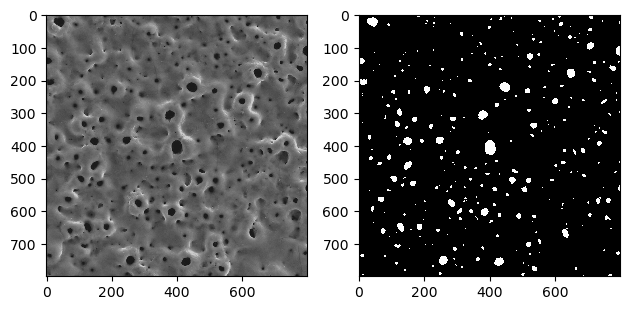

Shape of an augmented image: (800, 800, 1)


In [6]:
# to check if every is looking fine (also check orientation)
image_x = random.randint(0, len(X_train_aug)-1)

plt.figure()
plt.subplot(1,2,1)
imshow(X_train_aug[image_x], cmap='gray')  # for grayscale images
plt.subplot(1,2,2)
imshow(np.squeeze(Y_train_aug[image_x]))
plt.show()

print(f"Shape of an augmented image: {np.shape(X_train_aug[image_x])}")

In [7]:
# test images
X_test = np.zeros((len(test_ids), SIZE, SIZE, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), SIZE, SIZE, 1), dtype=bool)

print('Processing testing data')

# Iterate through all the training IDs
for index, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    # Construct the paths for the image and mask
    img_path = f"{TEST_PATH}{id_}/image/{id_}.jpg"
    mask_path = f"{TEST_PATH}{id_}/mask/{id_}.png"

    # Load and normalize the image
    image = imread(img_path, as_gray=True)
    image = np.uint8(image)
    image = np.expand_dims(image, axis=-1)  # Ensure image has 3 dimensions
    X_test[index] = image

    # Load and prepare the mask
    mask = imread(mask_path, as_gray=True)
    mask = mask > 0  # Convert grayscale to binary mask
    mask = np.expand_dims(mask, axis=-1)  # Ensure mask has 3 dimensions
    Y_test[index] = mask
    
print("X_test length: ", len(X_test))
print("Y_test length: ", len(Y_test))

Processing testing data


100%|██████████| 80/80 [00:00<00:00, 110.03it/s]

X_test length:  80
Y_test length:  80


In [8]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.1
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [9]:
### Model Architecture ###
### Conv - ReLU  (Full Atrous 8(135)_3x3_1x1_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Encoder_Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Bridge_Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Atrous_expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = Encoder_Atrous_contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)  # filter24 ACfilter24
conv2, pool2 = Encoder_Atrous_contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)       # filter48 ACfilter48 
conv3, pool3 = Encoder_Atrous_contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)         # filter96 Acfilter32
conv4, pool4 = Encoder_Atrous_contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)         # filter192 ACfilter64
conv5, _ = Bridge_Atrous_contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = Atrous_expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = Atrous_expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = Atrous_expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = Atrous_expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [10]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

2024-10-22 18:08:41.615892: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-22 18:08:41.615932: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-22 18:08:41.615996: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2024-10-22 18:08:41.617094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2024-10-22 18:08:41.717629: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2024-10-22 18:08:41.718317: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-22 18:08:42.398225: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-10-22 18:08

Epoch 1/100


2024-10-22 18:08:48.048219: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-10-22 18:08:50.035464: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


  1/240 [..............................] - ETA: 42:01 - loss: 0.9971 - binary_accuracy: 0.1597 - precision: 0.1594 - recall: 0.9311 - f1_score: 0.2722 - IoU: 0.1575

2024-10-22 18:08:53.077312: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-22 18:08:53.077356: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-22 18:08:53.079353: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


  2/240 [..............................] - ETA: 2:31 - loss: 0.9474 - binary_accuracy: 0.1802 - precision: 0.1661 - recall: 0.8844 - f1_score: 0.2796 - IoU: 0.1626 

2024-10-22 18:08:53.611196: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-10-22 18:08:53.622178: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-10-22 18:08:53.627204: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-22 18:08:53.630151: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_22_18_08_53
2024-10-22 18:08:53.631398: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2024_10_22_18_08_53/unet-587545dc99-4qwq4.trace.json.gz
2024-10-22 18:08:53.665019: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_22_18_08_53
2024-10-22 18:08:53.671841: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

240/240 [==============================] - 143s 556ms/step - loss: 0.2825 - binary_accuracy: 0.8552 - precision: 0.6218 - recall: 0.5098 - f1_score: 0.5093 - IoU: 0.4076 - val_loss: 0.1559 - val_binary_accuracy: 0.9582 - val_precision: 0.9478 - val_recall: 0.8007 - val_f1_score: 0.8804 - val_IoU: 0.7923
Epoch 2/100
240/240 [==============================] - 132s 550ms/step - loss: 0.1042 - binary_accuracy: 0.9632 - precision: 0.9035 - recall: 0.8761 - f1_score: 0.8868 - IoU: 0.7980 - val_loss: 0.1682 - val_binary_accuracy: 0.9643 - val_precision: 0.9484 - val_recall: 0.8382 - val_f1_score: 0.9024 - val_IoU: 0.8286
Epoch 3/100
240/240 [==============================] - 132s 550ms/step - loss: 0.0873 - binary_accuracy: 0.9692 - precision: 0.9145 - recall: 0.8976 - f1_score: 0.9046 - IoU: 0.8267 - val_loss: 0.1547 - val_binary_accuracy: 0.9616 - val_precision: 0.8809 - val_recall: 0.8977 - val_f1_score: 0.8998 - val_IoU: 0.8238
Epoch 4/100
240/240 [==============================] - 132s 5

In [11]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

Accuracy: 0.9722
Precision: 0.9415
Recall: 0.8936
F1 Score: 0.9169
IoU: 0.8466


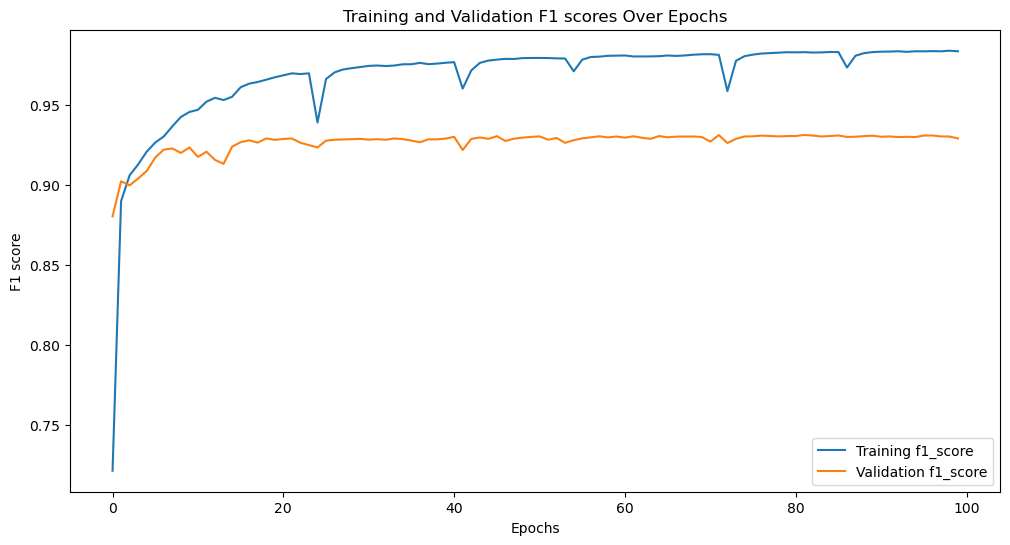

In [12]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [13]:
#######################################

In [14]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [15]:
### Model Architecture ###
### Conv - ReLU  (Full Atrous 8(135)_3x3_1x1_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Encoder_Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Bridge_Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Atrous_expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = Encoder_Atrous_contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)  # filter24 ACfilter24
conv2, pool2 = Encoder_Atrous_contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)       # filter48 ACfilter48 
conv3, pool3 = Encoder_Atrous_contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)         # filter96 Acfilter32
conv4, pool4 = Encoder_Atrous_contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)         # filter192 ACfilter64
conv5, _ = Bridge_Atrous_contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = Atrous_expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = Atrous_expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = Atrous_expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = Atrous_expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [16]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

2024-10-22 21:49:51.514413: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-22 21:49:51.514451: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-22 21:49:51.514547: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-10-22 21:49:51.514595: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
  1/240 [..............................] - ETA: 18:40 - loss: 0.6521 - binary_accuracy: 0.9556 - precision: 0.8747 - recall: 0.8653 - f1_score: 0.2056 - IoU: 0.1146

2024-10-22 21:49:57.282036: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-22 21:49:57.282072: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-22 21:49:57.282161: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  2/240 [..............................] - ETA: 2:27 - loss: 0.6288 - binary_accuracy: 0.9508 - precision: 0.8677 - recall: 0.8441 - f1_score: 0.1938 - IoU: 0.1074 

2024-10-22 21:49:58.101447: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-10-22 21:49:58.112127: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-10-22 21:49:58.116801: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-22 21:49:58.120159: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_22_21_49_58
2024-10-22 21:49:58.121278: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2024_10_22_21_49_58/unet-587545dc99-4qwq4.trace.json.gz
2024-10-22 21:49:58.163560: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_22_21_49_58
2024-10-22 21:49:58.170326: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

240/240 [==============================] - 137s 555ms/step - loss: 0.2453 - binary_accuracy: 0.9172 - precision: 0.8468 - recall: 0.6141 - f1_score: 0.5286 - IoU: 0.4305 - val_loss: 0.1601 - val_binary_accuracy: 0.9567 - val_precision: 0.9354 - val_recall: 0.8034 - val_f1_score: 0.8763 - val_IoU: 0.7857
Epoch 2/100
240/240 [==============================] - 132s 550ms/step - loss: 0.1035 - binary_accuracy: 0.9637 - precision: 0.9054 - recall: 0.8771 - f1_score: 0.8883 - IoU: 0.8003 - val_loss: 0.1592 - val_binary_accuracy: 0.9649 - val_precision: 0.9305 - val_recall: 0.8598 - val_f1_score: 0.9057 - val_IoU: 0.8341
Epoch 3/100
240/240 [==============================] - 132s 551ms/step - loss: 0.0882 - binary_accuracy: 0.9690 - precision: 0.9137 - recall: 0.8976 - f1_score: 0.9040 - IoU: 0.8257 - val_loss: 0.1579 - val_binary_accuracy: 0.9577 - val_precision: 0.8585 - val_recall: 0.9029 - val_f1_score: 0.8898 - val_IoU: 0.8070
Epoch 4/100
240/240 [==============================] - 132s 5

In [17]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

Accuracy: 0.9723
Precision: 0.9406
Recall: 0.8955
F1 Score: 0.9175
IoU: 0.8476


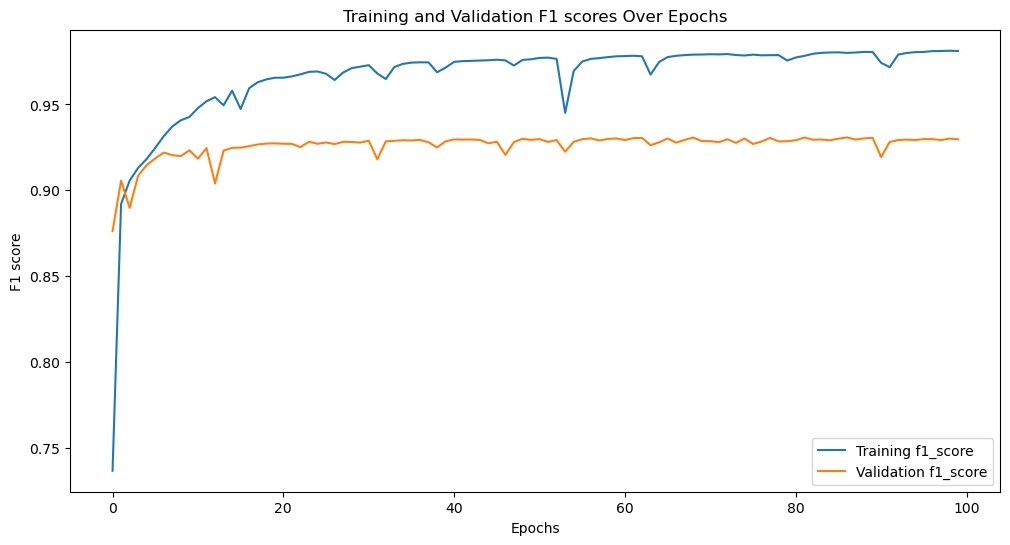

In [18]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [19]:
############################

In [20]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [21]:
### Model Architecture ###
### Conv - ReLU  (Full Atrous 8(135)_3x3_1x1_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Encoder_Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Bridge_Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Atrous_expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = Encoder_Atrous_contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)  # filter24 ACfilter24
conv2, pool2 = Encoder_Atrous_contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)       # filter48 ACfilter48 
conv3, pool3 = Encoder_Atrous_contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)         # filter96 Acfilter32
conv4, pool4 = Encoder_Atrous_contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)         # filter192 ACfilter64
conv5, _ = Bridge_Atrous_contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = Atrous_expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = Atrous_expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = Atrous_expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = Atrous_expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [22]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

2024-10-23 01:30:52.665728: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-23 01:30:52.665785: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-23 01:30:52.665940: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-10-23 01:30:52.665968: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
  1/240 [..............................] - ETA: 19:01 - loss: 0.9074 - binary_accuracy: 0.9369 - precision: 0.7729 - recall: 0.8958 - f1_score: 0.2829 - IoU: 0.1647

2024-10-23 01:30:58.508491: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-23 01:30:58.508532: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-23 01:30:58.508605: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  2/240 [..............................] - ETA: 2:27 - loss: 0.8720 - binary_accuracy: 0.9240 - precision: 0.7312 - recall: 0.8924 - f1_score: 0.2986 - IoU: 0.1758 

2024-10-23 01:30:59.358076: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-10-23 01:30:59.374379: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-10-23 01:30:59.379642: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-23 01:30:59.383073: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_23_01_30_59
2024-10-23 01:30:59.384398: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2024_10_23_01_30_59/unet-587545dc99-4qwq4.trace.json.gz
2024-10-23 01:30:59.422019: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_23_01_30_59
2024-10-23 01:30:59.428881: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

240/240 [==============================] - 137s 553ms/step - loss: 0.2998 - binary_accuracy: 0.8901 - precision: 0.7179 - recall: 0.5642 - f1_score: 0.4503 - IoU: 0.3602 - val_loss: 0.1623 - val_binary_accuracy: 0.9564 - val_precision: 0.8984 - val_recall: 0.8414 - val_f1_score: 0.8797 - val_IoU: 0.7909
Epoch 2/100
240/240 [==============================] - 132s 549ms/step - loss: 0.1073 - binary_accuracy: 0.9629 - precision: 0.9021 - recall: 0.8755 - f1_score: 0.8861 - IoU: 0.7967 - val_loss: 0.1536 - val_binary_accuracy: 0.9627 - val_precision: 0.8962 - val_recall: 0.8856 - val_f1_score: 0.9020 - val_IoU: 0.8276
Epoch 3/100
240/240 [==============================] - 132s 549ms/step - loss: 0.0896 - binary_accuracy: 0.9688 - precision: 0.9123 - recall: 0.8980 - f1_score: 0.9036 - IoU: 0.8250 - val_loss: 0.1546 - val_binary_accuracy: 0.9551 - val_precision: 0.8431 - val_recall: 0.9080 - val_f1_score: 0.8835 - val_IoU: 0.7966
Epoch 4/100
240/240 [==============================] - 132s 5

In [23]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

Accuracy: 0.9709
Precision: 0.9226
Recall: 0.9066
F1 Score: 0.9145
IoU: 0.8425


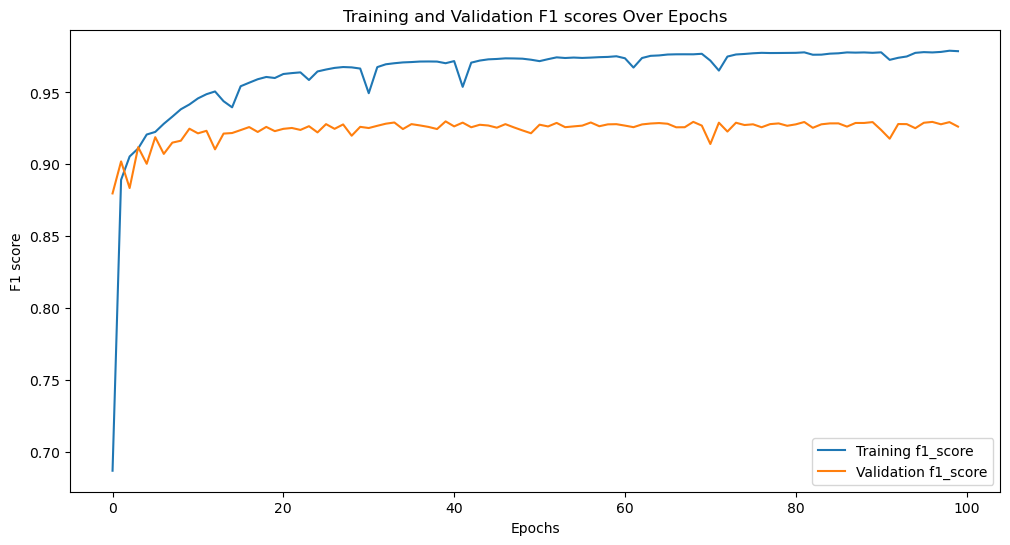

In [24]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
####################################

In [ ]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.1
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [ ]:
### Model Architecture ###
### Conv - ReLU  (Encoder+Bridge Atrous 8(135)_1x1) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = Atrous_contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = Atrous_contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = Atrous_contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = Atrous_contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = Atrous_contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [ ]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Encoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

In [ ]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

In [ ]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Encoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
############################

In [16]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [17]:
### Model Architecture ###
### Conv - ReLU  (Encoder+Bridge Atrous 8(135)_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = Atrous_contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = Atrous_contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = Atrous_contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = Atrous_contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = Atrous_contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [18]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Encoder+Bridge_Atrous_U-net_9_120img_8(135)_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

2024-10-19 07:02:43.533852: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-19 07:02:43.533901: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-19 07:02:43.534058: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-10-19 07:02:43.534428: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
  1/240 [..............................] - ETA: 14:24 - loss: 0.8986 - binary_accuracy: 0.9182 - precision: 0.7099 - recall: 0.8872 - f1_score: 0.3043 - IoU: 0.1795

2024-10-19 07:02:48.248618: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-19 07:02:48.248654: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-19 07:02:48.248746: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  2/240 [..............................] - ETA: 1:51 - loss: 0.8402 - binary_accuracy: 0.9068 - precision: 0.6818 - recall: 0.8717 - f1_score: 0.3192 - IoU: 0.1902 

2024-10-19 07:02:48.817390: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-10-19 07:02:48.823864: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-10-19 07:02:48.826643: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-19 07:02:48.829115: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_19_07_02_48
2024-10-19 07:02:48.829923: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2024_10_19_07_02_48/unet-587545dc99-4qwq4.trace.json.gz
2024-10-19 07:02:48.855905: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_19_07_02_48
2024-10-19 07:02:48.861496: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

240/240 [==============================] - 104s 418ms/step - loss: 0.2704 - binary_accuracy: 0.8942 - precision: 0.7520 - recall: 0.5429 - f1_score: 0.4951 - IoU: 0.3841 - val_loss: 0.1753 - val_binary_accuracy: 0.9560 - val_precision: 0.9142 - val_recall: 0.8209 - val_f1_score: 0.8763 - val_IoU: 0.7856
Epoch 2/100
240/240 [==============================] - 99s 414ms/step - loss: 0.1173 - binary_accuracy: 0.9586 - precision: 0.8862 - recall: 0.8662 - f1_score: 0.8733 - IoU: 0.7767 - val_loss: 0.1627 - val_binary_accuracy: 0.9643 - val_precision: 0.9267 - val_recall: 0.8601 - val_f1_score: 0.9042 - val_IoU: 0.8317
Epoch 3/100
 55/240 [=====>........................] - ETA: 1:15 - loss: 0.0981 - binary_accuracy: 0.9665 - precision: 0.9070 - recall: 0.8911 - f1_score: 0.8974 - IoU: 0.8149

KeyboardInterrupt: 

In [ ]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

In [ ]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Encoder+Bridge_Atrous_U-net_9_120img_8(135)_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
############################

In [ ]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [ ]:
### Model Architecture ###
### Conv - ReLU  (Encoder+Bridge Atrous 8(135)_1x1) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = Atrous_contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = Atrous_contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = Atrous_contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = Atrous_contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = Atrous_contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [ ]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Encoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

In [ ]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

In [ ]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Encoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
#############################

In [19]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.1
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [20]:
### Model Architecture ###
### Conv - ReLU  (Full Atrous 8(135)_1x1) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [21]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Full_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

2024-10-19 07:06:45.100594: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-19 07:06:45.100657: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-19 07:06:45.100892: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-10-19 07:06:45.101365: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
  1/240 [..............................] - ETA: 18:30 - loss: 0.7896 - binary_accuracy: 0.9551 - precision: 0.8501 - recall: 0.8824 - f1_score: 0.2324 - IoU: 0.1315

2024-10-19 07:06:50.818257: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-19 07:06:50.818311: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-19 07:06:50.818408: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  2/240 [..............................] - ETA: 2:16 - loss: 0.7693 - binary_accuracy: 0.9510 - precision: 0.8341 - recall: 0.8777 - f1_score: 0.2440 - IoU: 0.1391 

2024-10-19 07:06:51.456356: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-10-19 07:06:51.464799: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-10-19 07:06:51.468376: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-19 07:06:51.470974: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_19_07_06_51
2024-10-19 07:06:51.471951: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2024_10_19_07_06_51/unet-587545dc99-4qwq4.trace.json.gz
2024-10-19 07:06:51.499384: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_19_07_06_51
2024-10-19 07:06:51.506459: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

240/240 [==============================] - 118s 475ms/step - loss: 0.2830 - binary_accuracy: 0.9167 - precision: 0.8049 - recall: 0.6524 - f1_score: 0.4679 - IoU: 0.3732 - val_loss: 0.1674 - val_binary_accuracy: 0.9523 - val_precision: 0.8856 - val_recall: 0.8298 - val_f1_score: 0.8671 - val_IoU: 0.7707
Epoch 2/100
240/240 [==============================] - 113s 471ms/step - loss: 0.1162 - binary_accuracy: 0.9583 - precision: 0.8852 - recall: 0.8656 - f1_score: 0.8725 - IoU: 0.7754 - val_loss: 0.1622 - val_binary_accuracy: 0.9626 - val_precision: 0.9339 - val_recall: 0.8418 - val_f1_score: 0.8975 - val_IoU: 0.8203
Epoch 3/100
 55/240 [=====>........................] - ETA: 1:25 - loss: 0.0989 - binary_accuracy: 0.9648 - precision: 0.9037 - recall: 0.8840 - f1_score: 0.8922 - IoU: 0.8065

KeyboardInterrupt: 

In [ ]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

In [ ]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Full_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
###################################

In [ ]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [ ]:
### Model Architecture ###
### Conv - ReLU  (Full Atrous 8(135)_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [ ]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/VC_Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

In [ ]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

In [ ]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/VC_Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
###############################

In [ ]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [ ]:
### Model Architecture ###
### Conv - ReLU  (Full Atrous 8(135)_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [ ]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/VC_Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

In [ ]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

In [ ]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/VC_Final_Test_Full_Atrous_U-net_9_120img_8(135)_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
###############################################

In [28]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.1
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [29]:
### Model Architecture ###
### Conv - ReLU  (Both Atrous 8(135)_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def contracting_block(input, num_filters, dropout_rate):
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Atrous_expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = Atrous_contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = Atrous_contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = Atrous_contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = Atrous_contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = Atrous_expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = Atrous_expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = Atrous_expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = Atrous_expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [30]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/VC_Final_Test_Both_Atrous_U-net_9_120img_8(135)_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

2024-10-19 07:21:26.021309: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-19 07:21:26.021352: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-19 07:21:26.021477: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-10-19 07:21:26.021503: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
  1/240 [..............................] - ETA: 15:24 - loss: 0.7184 - binary_accuracy: 0.9122 - precision: 0.7014 - recall: 0.8708 - f1_score: 0.2579 - IoU: 0.1481

2024-10-19 07:21:30.919919: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-19 07:21:30.919956: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-19 07:21:30.920013: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  2/240 [..............................] - ETA: 2:26 - loss: 0.7051 - binary_accuracy: 0.8981 - precision: 0.6691 - recall: 0.8457 - f1_score: 0.2699 - IoU: 0.1562 

2024-10-19 07:21:31.632174: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-10-19 07:21:31.644718: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-10-19 07:21:31.648553: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-19 07:21:31.651240: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_19_07_21_31
2024-10-19 07:21:31.652345: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2024_10_19_07_21_31/unet-587545dc99-4qwq4.trace.json.gz
2024-10-19 07:21:31.683839: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_19_07_21_31
2024-10-19 07:21:31.689829: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

240/240 [==============================] - 138s 563ms/step - loss: 0.2577 - binary_accuracy: 0.9026 - precision: 0.7629 - recall: 0.6019 - f1_score: 0.5707 - IoU: 0.4579 - val_loss: 0.1593 - val_binary_accuracy: 0.9571 - val_precision: 0.9374 - val_recall: 0.8040 - val_f1_score: 0.8776 - val_IoU: 0.7878
Epoch 2/100
240/240 [==============================] - 134s 559ms/step - loss: 0.1021 - binary_accuracy: 0.9635 - precision: 0.9001 - recall: 0.8819 - f1_score: 0.8884 - IoU: 0.8004 - val_loss: 0.1651 - val_binary_accuracy: 0.9650 - val_precision: 0.9473 - val_recall: 0.8431 - val_f1_score: 0.9047 - val_IoU: 0.8326
Epoch 3/100
125/240 [==============>...............] - ETA: 1:02 - loss: 0.0839 - binary_accuracy: 0.9698 - precision: 0.9149 - recall: 0.9010 - f1_score: 0.9066 - IoU: 0.8299

KeyboardInterrupt: 

In [ ]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

In [ ]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/VC_Final_Test_Both_Atrous_U-net_9_120img_8(135)_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
###################################3

In [ ]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [ ]:
### Model Architecture ###
### Conv - ReLU  (Both Atrous 8(135)_1x1) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def contracting_block(input, num_filters, dropout_rate):
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Atrous_expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = Atrous_contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = Atrous_contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = Atrous_contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = Atrous_contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = Atrous_expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = Atrous_expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = Atrous_expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = Atrous_expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [ ]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/CV_Final_Test_Both_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

In [ ]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

In [ ]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/VC_Final_Test_Both_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
#####################################

In [ ]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [ ]:
### Model Architecture ###
### Conv - ReLU  (Both Atrous 8(135)_1x1) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def contracting_block(input, num_filters, dropout_rate):
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Atrous_expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = Atrous_contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = Atrous_contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = Atrous_contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = Atrous_contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = Atrous_expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = Atrous_expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = Atrous_expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = Atrous_expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [ ]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/VC_Final_Test_Both_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

In [ ]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

In [ ]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/VC_Final_Test_Both_Atrous_U-net_9_120img_8(135)_1x1_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
###################################################

In [8]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.1
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [9]:
### Model Architecture ###
### Conv - ReLU  (Decoder+Bridge Atrous 8(135)_1x1_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def contracting_block(input, num_filters, dropout_rate):
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Atrous_expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = Atrous_contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = Atrous_expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = Atrous_expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = Atrous_expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = Atrous_expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [10]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Decoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

2024-10-19 16:19:48.120094: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-19 16:19:48.120130: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-19 16:19:48.120178: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2024-10-19 16:19:48.122111: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2024-10-19 16:19:48.222604: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2024-10-19 16:19:48.222914: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-19 16:19:48.844949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-10-19 16:19

Epoch 1/100


2024-10-19 16:19:52.376253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-10-19 16:19:54.117883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


  1/240 [..............................] - ETA: 31:43 - loss: 1.1282 - binary_accuracy: 0.1798 - precision: 0.1620 - recall: 0.9249 - f1_score: 0.2756 - IoU: 0.1599

2024-10-19 16:19:56.912522: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-19 16:19:56.912614: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-19 16:19:56.913948: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


  2/240 [..............................] - ETA: 2:15 - loss: 1.0579 - binary_accuracy: 0.1966 - precision: 0.1727 - recall: 0.9121 - f1_score: 0.2902 - IoU: 0.1700 

2024-10-19 16:19:57.403904: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-10-19 16:19:57.412127: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-10-19 16:19:57.416073: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-19 16:19:57.418628: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_19_16_19_57
2024-10-19 16:19:57.419701: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2024_10_19_16_19_57/unet-587545dc99-4qwq4.trace.json.gz
2024-10-19 16:19:57.449829: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_19_16_19_57
2024-10-19 16:19:57.455044: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

240/240 [==============================] - 129s 506ms/step - loss: 0.3250 - binary_accuracy: 0.8389 - precision: 0.5829 - recall: 0.4396 - f1_score: 0.4498 - IoU: 0.3403 - val_loss: 0.1670 - val_binary_accuracy: 0.9534 - val_precision: 0.8892 - val_recall: 0.8328 - val_f1_score: 0.8703 - val_IoU: 0.7754
Epoch 2/100
240/240 [==============================] - 121s 504ms/step - loss: 0.1340 - binary_accuracy: 0.9500 - precision: 0.8619 - recall: 0.8388 - f1_score: 0.8473 - IoU: 0.7379 - val_loss: 0.1818 - val_binary_accuracy: 0.9592 - val_precision: 0.9695 - val_recall: 0.7874 - val_f1_score: 0.8823 - val_IoU: 0.7957
Epoch 3/100
240/240 [==============================] - 121s 503ms/step - loss: 0.0899 - binary_accuracy: 0.9678 - precision: 0.9070 - recall: 0.8975 - f1_score: 0.9005 - IoU: 0.8201 - val_loss: 0.1472 - val_binary_accuracy: 0.9638 - val_precision: 0.8929 - val_recall: 0.8969 - val_f1_score: 0.9057 - val_IoU: 0.8337
Epoch 4/100
240/240 [==============================] - 121s 5

In [11]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

Accuracy: 0.9734
Precision: 0.9524
Recall: 0.8896
F1 Score: 0.9199
IoU: 0.8517


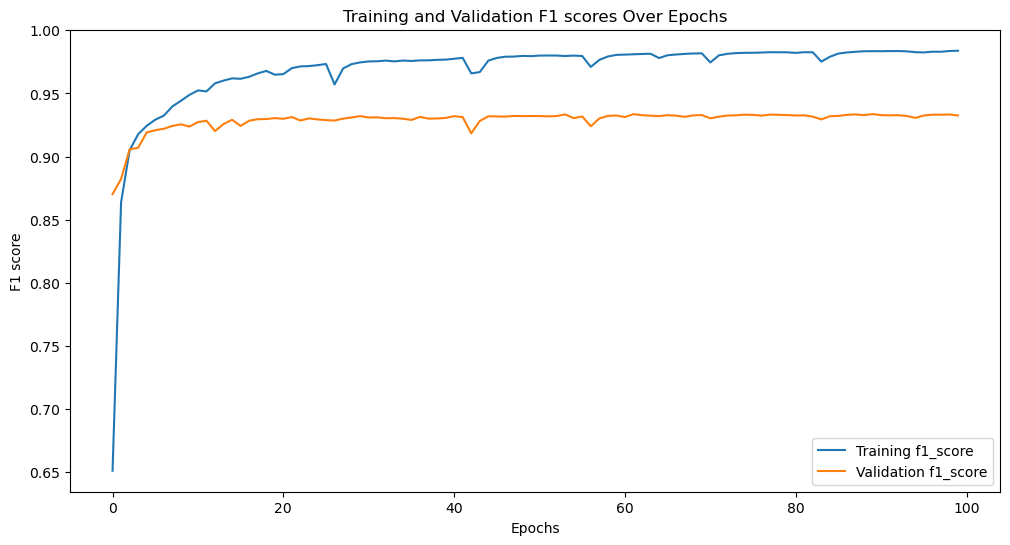

In [12]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Decoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [ ]:
######################################

In [8]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [9]:
### Model Architecture ###
### Conv - ReLU  (Decoder+Bridge Atrous 8(135)_1x1_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def contracting_block(input, num_filters, dropout_rate):
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Atrous_expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = Atrous_contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = Atrous_expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = Atrous_expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = Atrous_expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = Atrous_expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [10]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Decoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

2024-10-20 03:57:23.163794: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-20 03:57:23.163829: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-20 03:57:23.163917: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2024-10-20 03:57:23.165117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2024-10-20 03:57:23.265699: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2024-10-20 03:57:23.266534: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-20 03:57:23.922243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-10-20 03:57

Epoch 1/100


2024-10-20 03:57:27.370314: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-10-20 03:57:29.254075: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


  1/240 [..............................] - ETA: 31:55 - loss: 1.1904 - binary_accuracy: 0.2059 - precision: 0.1618 - recall: 0.8867 - f1_score: 0.2737 - IoU: 0.1585

2024-10-20 03:57:32.038365: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-20 03:57:32.038404: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-20 03:57:32.039585: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


  2/240 [..............................] - ETA: 2:13 - loss: 1.1114 - binary_accuracy: 0.2246 - precision: 0.1719 - recall: 0.8654 - f1_score: 0.2868 - IoU: 0.1676 

2024-10-20 03:57:32.527013: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-10-20 03:57:32.535437: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-10-20 03:57:32.539150: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-20 03:57:32.541527: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_20_03_57_32
2024-10-20 03:57:32.542483: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2024_10_20_03_57_32/unet-587545dc99-4qwq4.trace.json.gz
2024-10-20 03:57:32.571329: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_20_03_57_32
2024-10-20 03:57:32.577026: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

240/240 [==============================] - 130s 510ms/step - loss: 0.3160 - binary_accuracy: 0.8393 - precision: 0.5744 - recall: 0.4541 - f1_score: 0.4434 - IoU: 0.3529 - val_loss: 0.1552 - val_binary_accuracy: 0.9582 - val_precision: 0.8909 - val_recall: 0.8626 - val_f1_score: 0.8871 - val_IoU: 0.8030
Epoch 2/100
240/240 [==============================] - 121s 504ms/step - loss: 0.1033 - binary_accuracy: 0.9646 - precision: 0.9046 - recall: 0.8837 - f1_score: 0.8914 - IoU: 0.8054 - val_loss: 0.1521 - val_binary_accuracy: 0.9626 - val_precision: 0.8960 - val_recall: 0.8853 - val_f1_score: 0.9014 - val_IoU: 0.8267
Epoch 3/100
240/240 [==============================] - 121s 504ms/step - loss: 0.0872 - binary_accuracy: 0.9694 - precision: 0.9127 - recall: 0.9013 - f1_score: 0.9054 - IoU: 0.8280 - val_loss: 0.1622 - val_binary_accuracy: 0.9572 - val_precision: 0.8528 - val_recall: 0.9076 - val_f1_score: 0.8887 - val_IoU: 0.8050
Epoch 4/100
240/240 [==============================] - 121s 5

In [11]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

Accuracy: 0.9732
Precision: 0.9467
Recall: 0.8942
F1 Score: 0.9197
IoU: 0.8513


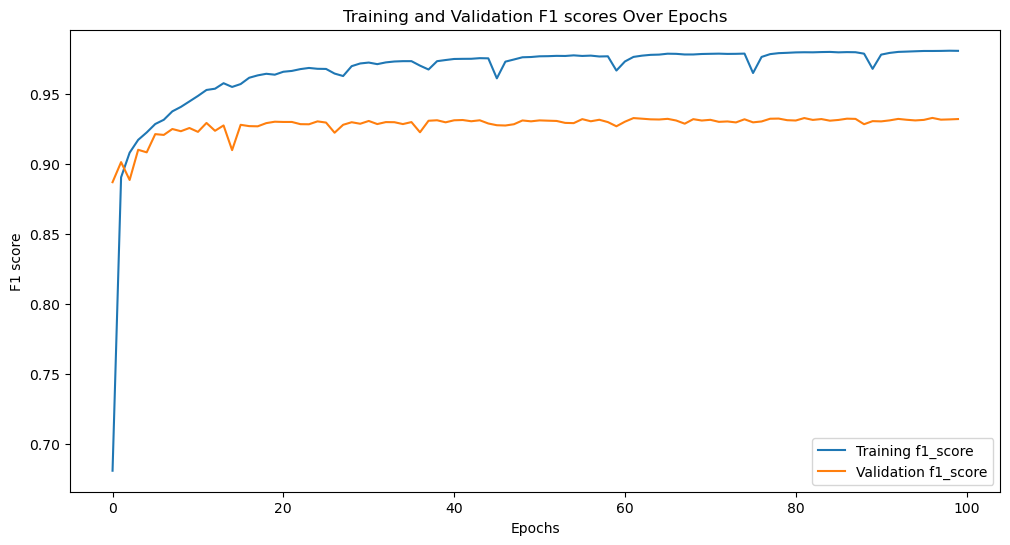

In [12]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Decoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()

In [13]:
######################################

In [14]:
NUM_FILTERS = 24
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0005
CLIPVALUE = 1
BATCH_SIZE = 4

In [15]:
### Model Architecture ###
### Conv - ReLU  (Decoder+Bridge Atrous 8(135)_1x1_3x3) ###

def atrous_conv_block(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=1)(input)
    conv2 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=3)(input)
    conv3 = tf.keras.layers.Conv2D(num_filters//3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dilation_rate=5)(input)
    concat = tf.keras.layers.concatenate([conv1, conv2, conv3])
    return concat

def Atrous_contracting_block(input, num_filters, dropout_rate):
    conv = atrous_conv_block(input, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (1, 1), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def contracting_block(input, num_filters, dropout_rate):
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(drop)
    return drop, pool

def Atrous_expansive_block(input, skip_tensor, num_filters, dropout_rate):
    upsample = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    concat = tf.keras.layers.concatenate([upsample, skip_tensor])
    conv = atrous_conv_block(concat, num_filters)
    conv = tf.keras.layers.Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
    drop = tf.keras.layers.Dropout(dropout_rate)(conv)
    return drop

# Input layer
input_layer = tf.keras.layers.Input(shape=(SIZE, SIZE, IMG_CHANNELS))
normalized = tf.keras.layers.Lambda(lambda x: x / 255.0)(input_layer)

# Contracting path
conv1, pool1 = contracting_block(normalized, NUM_FILTERS, DROPOUT_RATE)
conv2, pool2 = contracting_block(pool1, NUM_FILTERS*2, DROPOUT_RATE)
conv3, pool3 = contracting_block(pool2, NUM_FILTERS*4, DROPOUT_RATE)
conv4, pool4 = contracting_block(pool3, NUM_FILTERS*8, DROPOUT_RATE)
conv5, _ = Atrous_contracting_block(pool4, NUM_FILTERS*16, DROPOUT_RATE)

# Expansive path
expan1 = Atrous_expansive_block(conv5, conv4, NUM_FILTERS*8, DROPOUT_RATE)
expan2 = Atrous_expansive_block(expan1, conv3, NUM_FILTERS*4, DROPOUT_RATE)
expan3 = Atrous_expansive_block(expan2, conv2, NUM_FILTERS*2, DROPOUT_RATE)
expan4 = Atrous_expansive_block(expan3, conv1, NUM_FILTERS, DROPOUT_RATE)

# Output layer
final_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(expan4)

# Create model
model = tf.keras.Model(inputs=[input_layer], outputs=[final_output])
# model.summary()

In [16]:
callbacks = [
tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_f1_score', mode='max', restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Choose optimizer, loss function, and metrics. Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=CLIPVALUE)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[accuracy_metric, precision_metric, recall_metric, f1_score, IoU])

# Train the model
results = model.fit(X_train_aug, Y_train_aug, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

# Save the trained model
model.save(f'/home/vcpuser/Final segmented_/Final_Test_Decoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.keras')

2024-10-20 07:19:33.120228: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-20 07:19:33.120266: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-20 07:19:33.120467: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2024-10-20 07:19:33.120516: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
  1/240 [..............................] - ETA: 15:49 - loss: 1.4180 - binary_accuracy: 0.9365 - precision: 0.7710 - recall: 0.8966 - f1_score: 0.2862 - IoU: 0.1670

2024-10-20 07:19:38.262398: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-10-20 07:19:38.262442: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-10-20 07:19:38.262523: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  2/240 [..............................] - ETA: 2:10 - loss: 1.3100 - binary_accuracy: 0.9219 - precision: 0.7234 - recall: 0.8963 - f1_score: 0.3020 - IoU: 0.1782 

2024-10-20 07:19:38.948189: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-10-20 07:19:38.955377: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2024-10-20 07:19:38.958902: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-10-20 07:19:38.961391: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_20_07_19_38
2024-10-20 07:19:38.962490: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2024_10_20_07_19_38/unet-587545dc99-4qwq4.trace.json.gz
2024-10-20 07:19:38.995747: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2024_10_20_07_19_38
2024-10-20 07:19:39.002030: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

240/240 [==============================] - 125s 506ms/step - loss: 0.3372 - binary_accuracy: 0.8810 - precision: 0.6648 - recall: 0.6019 - f1_score: 0.4918 - IoU: 0.3866 - val_loss: 0.1558 - val_binary_accuracy: 0.9602 - val_precision: 0.9060 - val_recall: 0.8575 - val_f1_score: 0.8922 - val_IoU: 0.8115
Epoch 2/100
240/240 [==============================] - 121s 503ms/step - loss: 0.1089 - binary_accuracy: 0.9627 - precision: 0.9007 - recall: 0.8760 - f1_score: 0.8857 - IoU: 0.7962 - val_loss: 0.1525 - val_binary_accuracy: 0.9657 - val_precision: 0.9320 - val_recall: 0.8633 - val_f1_score: 0.9081 - val_IoU: 0.8383
Epoch 3/100
240/240 [==============================] - 121s 503ms/step - loss: 0.0900 - binary_accuracy: 0.9690 - precision: 0.9134 - recall: 0.8982 - f1_score: 0.9042 - IoU: 0.8260 - val_loss: 0.1493 - val_binary_accuracy: 0.9609 - val_precision: 0.8736 - val_recall: 0.9035 - val_f1_score: 0.8984 - val_IoU: 0.8213
Epoch 4/100
240/240 [==============================] - 121s 5

In [17]:
### validation image evaluation metrics ###
def batch_predict(model, data, batch_size=10):
    predictions = []
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i + batch_size]
        batch_predictions = model.predict(batch_data)
        predictions.append(batch_predictions)
    return np.concatenate(predictions, axis=0)

# Make predictions in batches
batch_size = 10  # Adjust batch size according to your GPU memory capacity
prediction_validation = batch_predict(model, X_test, batch_size=batch_size)

# Convert predictions to binary
prediction_validation_binary = prediction_validation > 0.5

# Calculate precision, recall, and F1 score
accuracy_validation = metrics.accuracy_score(Y_test.flatten(), prediction_validation_binary.flatten())
precision_validation = metrics.precision_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
recall_validation = metrics.recall_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
f1_validation = metrics.f1_score(Y_test.flatten(), prediction_validation_binary.flatten(), average='binary')
IoU_validation = metrics.jaccard_score(Y_test.flatten(), prediction_validation_binary.flatten())

# Print out the results
print(f'Accuracy: {accuracy_validation:.4f}')
print(f'Precision: {precision_validation:.4f}')
print(f'Recall: {recall_validation:.4f}')
print(f'F1 Score: {f1_validation:.4f}')
print(f'IoU: {IoU_validation:.4f}')

Accuracy: 0.9714
Precision: 0.9260
Recall: 0.9062
F1 Score: 0.9160
IoU: 0.8451


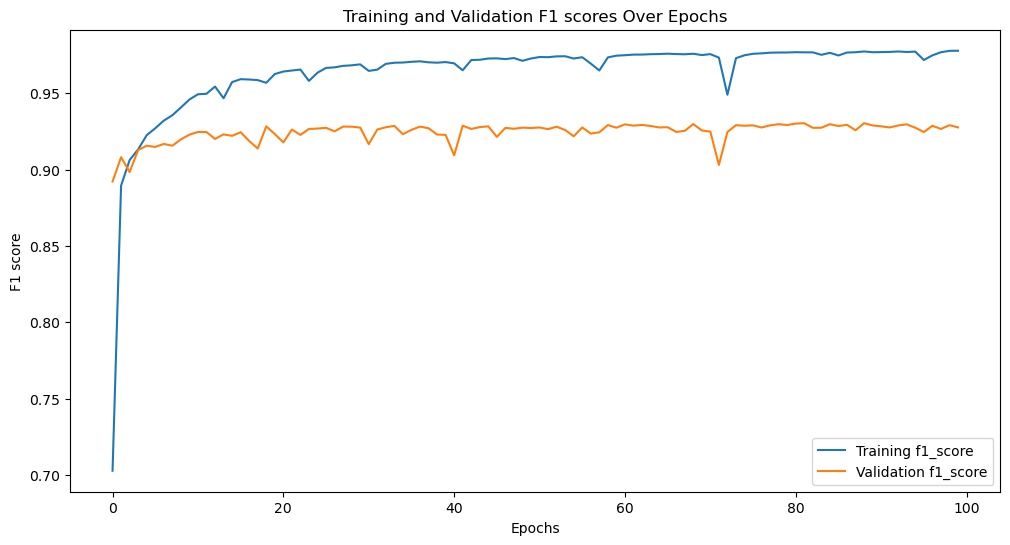

In [18]:
# Create a DataFrame from the training history and save to a Excel file
history_df = pd.DataFrame(results.history)
history_df.to_excel(f'/home/vcpuser/Final segmented_/Final_Test_Decoder+Bridge_Atrous_U-net_9_120img_8(135)_1x1_3x3_filter{NUM_FILTERS}_Drop{DROPOUT_RATE}_LR{LEARNING_RATE}_clip{CLIPVALUE}_batchsize{BATCH_SIZE}.xlsx', index=False)

# Plot the training F1 score and validation F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results.history['f1_score'], label='Training f1_score')
plt.plot(results.history['val_f1_score'], label='Validation f1_score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.title('Training and Validation F1 scores Over Epochs')
plt.show()